# TODO: IMPROVE

In [8]:
# Import internal libraries
import json
from copy import deepcopy

# Import custom libraries
from helper import intersection, factors

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
# SET sweep data
setdata = pd.read_csv(f"../data/sweep/setsweep33_real.csv.gz", delimiter="\t", names=["addr", "t", "vwl", "vbl", "pw"] + [f"gi[{i}]" for i in range(48)] + [f"gf[{i}]" for i in range(48)])
setdata = pd.concat([setdata[["addr","t","vwl","vbl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(48)])
setdata = setdata[setdata["gf"] != 0]
setdata

,addr,t,vwl,vbl,pw,gi,gf
0,64975,1.697692e+09,0,0,1,39,40
1,44558,1.697692e+09,0,1,1,8,8
2,56402,1.697692e+09,0,2,1,14,14
3,1098,1.697692e+09,0,3,1,42,43
4,50029,1.697692e+09,0,4,1,51,51
...,...,...,...,...,...,...,...
74613,50999,1.697753e+09,254,27,1,15,59
74614,35678,1.697753e+09,254,28,1,13,62
74615,56431,1.697753e+09,254,29,1,16,59
74616,23422,1.697753e+09,254,30,1,13,62


tailstart, avgopt, tailstop = 17 24 25


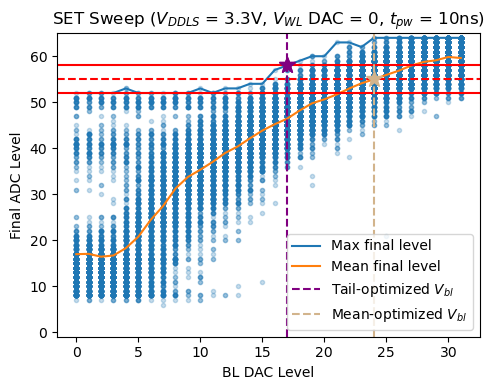

FileNotFoundError: [Errno 2] No such file or directory: 'configs/config_1bpc_lvl1_0000.json'

In [10]:
# FIRST-ORDER OPTIMIZATION
# Iterate over number of bits per cell
for bpc in range(1, 3):
  # Load configuration template
  bpc_config = json.load(open(f"../settings/{bpc}bpc_best_manual.json"))
  for i, level_settings in enumerate(bpc_config["level_settings"]):
    # Get levels
    write_between = level_settings["adc_lower_write_ref_lvl"], level_settings["adc_upper_write_ref_lvl"]
    read_lvl = level_settings["adc_upper_read_ref_lvl"]

    # Generate SET experiment configs
    configs = []
    if (i != 0): # No SET optimization needed for lowest level
      # Get data
      d = setdata[(setdata["gi"].isin(range(write_between[0]))) & (setdata["pw"] == 1) & (setdata["vwl"] == 0)][["vbl","gf"]]

      # Plot sweep
      pw = 1
      plt.figure(figsize=(5,4))
      plt.scatter(d['vbl'], d['gf'], marker='.', alpha=0.25)
      plt.plot(d.groupby('vbl').max(), label="Max final level")
      plt.plot(d.groupby('vbl').mean(), label="Mean final level")
      # plt.plot(d.groupby('vbl').min(), label="Min final level")
      plt.axhline(write_between[0], color='r')
      plt.axhline((write_between[1] + write_between[0])/2, color='r', linestyle='--')
      plt.axhline(write_between[1], color='r')
      
      # Get tail-start, avg-opt, tail-stop
      tailstart = intersection(np.array([0,31]),np.array([write_between[1], write_between[1]]), d.groupby('vbl').max().reset_index()['vbl'], d.groupby('vbl').max().reset_index()['gf'])
      avgopt = intersection(np.array([0,31]),np.array([(write_between[1] + write_between[0])/2, (write_between[1] + write_between[0])/2]), d.groupby('vbl').mean().reset_index()['vbl'], d.groupby('vbl').mean().reset_index()['gf'])
      tailstop = intersection(np.array([0,31]),np.array([write_between[0], write_between[0]]), d.groupby('vbl').min().reset_index()['vbl'], d.groupby('vbl').min().reset_index()['gf'])
      plt.axvline(tailstart[0][0], color='purple', linestyle='--', label="Tail-optimized $V_{bl}$")
      plt.axvline(avgopt[0][0], color='tan', linestyle='--', label="Mean-optimized $V_{bl}$")
      plt.plot(*tailstart, '*', color='purple', markersize=12)
      plt.plot(*avgopt, '*', color='tan', markersize=12)
      # plt.axvline(tailstop, color='pink', linestyle='--', label="Tail-optimized $V_{bl}$ stop")
      tailstart, avgopt= int(np.round(tailstart[0][0])), int(np.round(avgopt[0][0]))
      try:
        tailstop = int(np.round(tailstop[0][0]))
      except IndexError:
        tailstop = 25
      print("tailstart, avgopt, tailstop =", tailstart, avgopt, tailstop)

      # Final plot stuff
      plt.title(f"SET Sweep ($V_{{DDLS}}$ = 3.3V, $V_{{WL}}$ DAC = 0, $t_{{pw}}$ = {pw*10}ns)", y=1)
      plt.xlabel("BL DAC Level")
      plt.ylabel("Final ADC Level")
      plt.ylim(-1, 65)
      plt.legend()
      plt.tight_layout()
      plt.savefig(f"../analysis/figs/{bpc}bpc_lvl{i}_sweep_opt.pdf")
      plt.show()

      # Generate configurations
      stop = 31
      j = 0 # experiment number
      for pw in range(1, 2):
        for start in range(tailstart, avgopt + 1):
          for step in sorted(list(factors(stop - start)))[:4]:
            # Copy config template from form.json
            config = deepcopy(bpc_config)

            # Update level settings
            config["level_settings"][i].update({"pw_set_start": pw, "pw_set_stop": pw + 1, "bl_dac_set_lvl_start": start, "bl_dac_set_lvl_stop": stop, "bl_dac_set_lvl_step": step})

            # Write out experiments as configs
            with open(f"configs/config_{bpc}bpc_lvl{i}_{str(j).zfill(4)}.json", 'w') as outf:
              json.dump(config, outf, indent=1)

            # Increment j
            j += 1
